<code>create_obs_SIE_anoms.ipynb</code>.  This notebook calculates the anomalous sea ice extent for our observed sea ice extents.  We'll calculate them for both NASA Bootstrap (NSIDC_0079) and NASA Team (NSIDC_0081).

This notebook prepares our S2S sea ice extent forecast data for McGraw et al (2021).  Here, we read in sea ice extent data from the following sea ice observations, available from the SIPN portal:
<li> NSIDC_0079 (NASA Bootstrap) </li>
<li> NSIDC_0051 (NASA Team) </li>

For each observational data set, we import the observations that. We calculate two different climatologies--one where we use the entire SIE data set from 1989-2014, and a second where we only use the years in our reforecast common reforecast data set. 

$$SIE_{clim}(doy) = \frac{1}{N} \cdot \sum_{i=1}^{N} SIE_{clim}(doy,i),$$

where $l$ is the forecast lead time, $doy$ is the day of year, $i$ indicates the year of the forecast (so the forecast date is the day of the year and the year), and $N$ is the number of forecast years. 

Finally, we estimate the anomalous SIE for each forecast by removing the climatological SIE from the actual SIE,

$$SIE_{anom}(doy, i) = SIE(doy, i) - SIE_{clim}(doy)$$

We output $SIE$, $SIE_{clim}$, and $SIE_{anom}$ to a dataframe. 


In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_obs_climatology

## Functions

<li>1) <code>load_model</code> loads obs netCDF files from SIPN </li>
<li> 2) <code>create_aggregate_regions</code> Combine some of the NSIDC MASIE regions together for simplicity (e.g., Kara and Laptev Seas combined to create Kara-Laptev Sea region) </li>
<li> 3) <code>create_obs_climatology</code>: climatology for observations
 
  *  Group by region, lead time, and valid date of year 
  *  Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>. 
  *  Subtract <code>SIE_clim</code> from <code>SIE</code> </li>

In [33]:
obs_name = 'NSIDC_0079'
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Create aggregate regions

In [34]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
obs_SIE['obs name'] = obs_name

Create a copy of <code>obs_SIE</code> that only includes the years in the common reforecast period

In [35]:
common_yrs = np.arange(1999,2015)
obs_SIE_CF = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(common_yrs)]

Climatologies--one for the full obs, one for the common reforecast period only.  We'll also compare the impact of removing 2015-2019. 

In [36]:
obs_SIE_v2 = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year < 2015]
obs_SIE_v2 = create_obs_climatology(obs_SIE_v2)
obs_SIE = create_obs_climatology(obs_SIE)
obs_SIE_CF = create_obs_climatology(obs_SIE_CF)

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_preprocess.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIE['valid day of year'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_preprocess.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIE['SIE clim'] = SIE.groupby(['region','valid day of year'])['SIE'].transform('mean')
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/ma

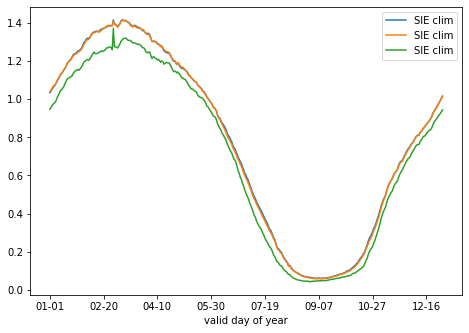

In [40]:
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
obs_SIE_v2.groupby(['region','valid day of year']).mean().xs('Baffin Bay').plot(y='SIE clim',ax=ax1)
obs_SIE.groupby(['region','valid day of year']).mean().xs('Baffin Bay').plot(y='SIE clim',ax=ax1)
obs_SIE_CF.groupby(['region','valid day of year']).mean().xs('Baffin Bay').plot(y='SIE clim',ax=ax1)